In [1]:
import pandas as pd
%matplotlib inline

trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


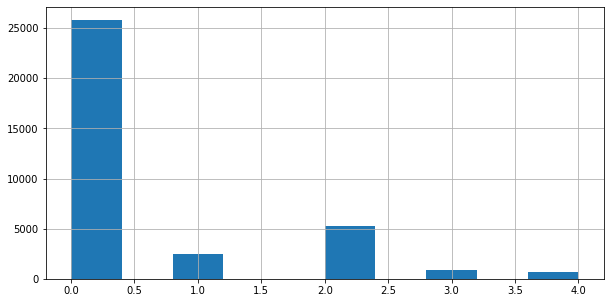

In [2]:
trainLabels['level'].hist(figsize = (10, 5))

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib.pyplot as plt

In [4]:
base_image_dir = os.path.join('train/')
df = pd.read_csv(os.path.join('trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,0,train/29147_right.jpeg
1,2,train/20777_right.jpeg
2,0,train/6193_right.jpeg
3,0,train/29673_left.jpeg
4,0,train/38758_right.jpeg
5,0,train/19289_left.jpeg
6,0,train/10163_right.jpeg
7,0,train/32998_left.jpeg
8,0,train/28865_right.jpeg
9,0,train/26293_right.jpeg


In [11]:
def crop_image_to_aspect(image):
    # load image
    tar=1.2
    npim = image2np(image)*255 # convert to numpy array in range 0-255
    npim = npim.astype(np.uint8)
    image_bw = cv2.cvtColor(npim, cv2.COLOR_RGB2GRAY)
    
    #cv2.imread(image)
    # compute aspect ratio
    h, w = image_bw.shape[0], image_bw.shape[1]
    sar = h / w if h > w else w / h
    if sar < tar:
        return pil2tensor(image, dtype=np.float32)/255
    else:
        k = 0.5 * (1.0 - (tar / sar))
        if h > w:
            lb = int(k * h)
            ub = h - lb
            cropped = image[:,lb:ub, :]
            cropped=pil2tensor(cropped, dtype=np.float32)/255
        else:
            lb = int(k * w)
            ub = w - lb
            cropped = image[:,:, lb:ub]
            cropped=pil2tensor(cropped, dtype=np.float32)/255
        return cropped



vs = []
index=1
for i in random.sample(range(1,35000),4000):
    image = cv2.imread(df["path"][i])
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(image_hsv)
    vs.append(np.mean(v))
    if index%1000==0:
        print(index)
    index+=1
global_mean_v = int(np.mean(np.array(vs)))



1000
2000
3000
4000


In [13]:
def brighten_image_hsv(image):
    global_mean_v=82
    npim = image2np(image)*255 # convert to numpy array in range 0-255
    npim = npim.astype(np.uint8) # convert to int
    image_hsv = cv2.cvtColor(npim, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(image_hsv)
    mean_v = int(np.mean(v))
    v = v - mean_v + global_mean_v
    image_hsv = cv2.merge((h, s, v))
    image_bright = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    
    return  pil2tensor(image_bright, dtype=np.float32)/255


In [14]:
from fastai import *
from fastai.vision import *

In [16]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)
import warnings
warnings.filterwarnings('ignore')

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [17]:
use_cuda=True

In [18]:
custom_trans = TfmPixel(brighten_image_hsv) # wrap in TfmPixel to create a valid transform
#tfms = [[custom_trans()],[]] # set your custom transform for training dataset only

tfms = get_transforms(xtra_tfms=[custom_trans()],do_flip=False,flip_vert=False,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.5,p_lighting=0.5)


In [19]:
df0=df.loc[df["level"]==0].sample(n=700)
df1=df.loc[df["level"]==1].sample(n=700)
df2=df.loc[df["level"]==2].sample(n=700)
df3=df.loc[df["level"]==3].sample(n=700)
df4=df.loc[df["level"]==4].sample(n=700)
df1=df1.append([df0,df2,df3]).reset_index(drop=True)

In [21]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df1,test_size=0.2)

In [22]:
bs = 50 #smaller batch size is better for training, but may take longer
sz=256

src = (ImageList.from_df(df=df1,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df1))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [23]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),device='cuda:0')

In [24]:
import torchvision

learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])


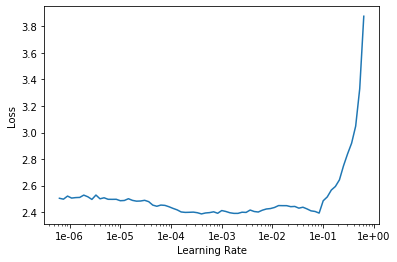

In [163]:
learn.lr_find()
learn.recorder.plot()

In [25]:
use_cuda=True
learn.fit_one_cycle(4,max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,2.326810,3.153063,0.069519,0.000000,14:56
1,1.785492,1.919574,0.262032,0.000000,13:38
2,1.560293,2.054420,0.281640,0.000000,13:34
3,1.377849,1.663568,0.335116,0.000000,13:38


In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

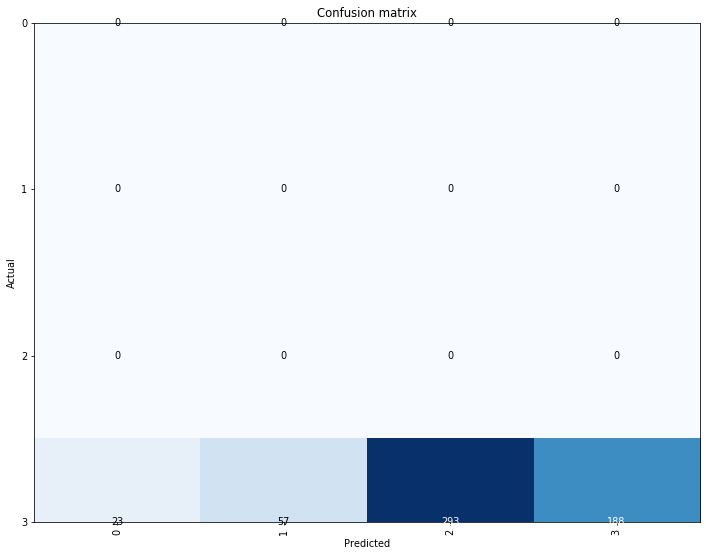

In [34]:
interp.plot_confusion_matrix(figsize=(10,30), dpi=70)